In [22]:
import os
from dotenv import load_dotenv
_ = load_dotenv()

profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [23]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4o-mini")

class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

llm_router = llm.with_structured_output(Router)

In [24]:
from prompts import triage_system_prompt, triage_user_prompt, agent_system_prompt

from langchain_core.tools import tool
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"



### Define tools for managing memory and retrieving information

In [25]:
from langgraph.store.memory import InMemoryStore
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-small"}
)

In [26]:
# Importar herramientas de gestión de memoria de LangMem
from langmem import create_manage_memory_tool, create_search_memory_tool

# Crear herramienta para gestionar memoria
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)

# Crear herramienta para buscar en memoria
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

print("🧠 Herramientas de memoria creadas:")
print(f"📝 {manage_memory_tool.name}: {manage_memory_tool.description}")
print(f"🔍 {search_memory_tool.name}: {search_memory_tool.description}")

🧠 Herramientas de memoria creadas:
📝 manage_memory: Create, update, or delete a memory to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.
🔍 search_memory: Search your long-term memories for information relevant to your current context.


In [27]:
# Explorar las herramientas de memoria
print("=" * 50)
print("🔧 MANAGE MEMORY TOOL")
print("=" * 50)
print(f"Name: {manage_memory_tool.name}")
print(f"Description: {manage_memory_tool.description}")
print(f"Args: {manage_memory_tool.args}")

print("\n" + "=" * 50)
print("🔍 SEARCH MEMORY TOOL")
print("=" * 50)
print(f"Name: {search_memory_tool.name}")
print(f"Description: {search_memory_tool.description}")
print(f"Args: {search_memory_tool.args}")

🔧 MANAGE MEMORY TOOL
Name: manage_memory
Description: Create, update, or delete a memory to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.
Args: {'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Content'}, 'action': {'default': 'create', 'enum': ['create', 'update', 'delete'], 'title': 'Action', 'type': 'string'}, 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}], 'default': None, 'title': 'Id'}}

🔍 SEARCH MEMORY TOOL
Name: search_memory
Description: Search your long-term memories for information relevant to your current context.
Args: {'query': {'t

In [28]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [29]:
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt_instructions["agent_instructions"], 
                **profile
            )
        }
    ] + state['messages']

In [30]:
from langgraph.prebuilt import create_react_agent
tools= [
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
response_agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=tools,
    prompt=create_prompt,
    # Use this to ensure the store is passed to the agent 
    store=store
)

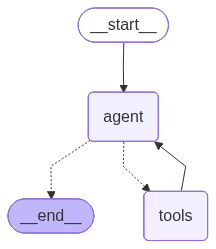

================================ Human Message =================================

who is jim?
================================== Ai Message ==================================
Tool Calls:
  search_memory (call_LmyiQzjykhgeG3ub7IDxQq3d)
 Call ID: call_LmyiQzjykhgeG3ub7IDxQq3d
  Args:
    query: jim
================================= Tool Message =================================
Name: search_memory

[]
================================== Ai Message ==================================

I don't have any information about Jim stored in my memory. If you provide me with more context or details, I can help you better.


In [42]:
config = {"configurable":{"langgraph_user_id":"lance"}}
response = response_agent.invoke(
    {"messages": [{"role":"user", "content":"who is jim?"}]},
    config=config
)

display(Image(response_agent.get_graph(xray=True).draw_mermaid_png()))

for m in response["messages"]:
    m.pretty_print()

In [ ]:
store.list_namespaces()

[]

In [32]:
store.search(('email_assistant', 'lance', 'collection'))

[]

In [33]:
store.search(('email_assistant', 'lance', 'collection'), query="jim")

[]

### Create the rest of the agent

In [34]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [35]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [36]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
    profile=profile,  # ✅ Pasar el diccionario completo
    triage_rules=prompt_instructions["triage_rules"],
    agent_instructions=prompt_instructions["agent_instructions"]
    )
    user_prompt = triage_user_prompt.format(
    email_from=author,      # ✅ Nombres correctos
    email_to=to, 
    email_subject=subject, 
    email_body=email_thread
    ) 
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    print("--------")
    print(f"classification : {result.classification}")
    print("--------")
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

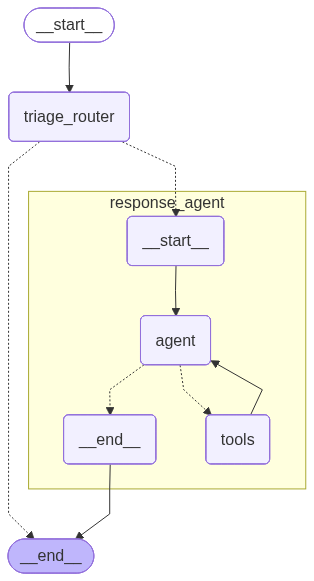

In [41]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [38]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [39]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

--------
classification : respond
--------
📧 Classification: RESPOND - This email requires a response


In [40]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_O2P4KCxxY8kVnmKb7gPQJnsD)
 Call ID: call_O2P4KCxxY8kVnmKb7gPQJnsD
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thanks for reaching out. I appreciate you taking the time to review the API documentation. 

I'll take a 

In [43]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow up",
    "email_thread": """Hi John,

Any update on my previous ask?""",
}

response = email_agent.invoke({"email_input": email_input}, config=config)

for m in response["messages"]:
    m.pretty_print()

--------
classification : respond
--------
📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\n\nAny update on my previous ask?'}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_y5tjF4GQhPVNeVwAnfSnLuAm)
 Call ID: call_y5tjF4GQhPVNeVwAnfSnLuAm
  Args:
    to: alice.smith@company.com
    subject: Re: Follow up
    content: Hi Alice,

Thank you for your email. I apologize for the delay. I am currently reviewing your previous request and will have an update for you shortly.

Best regards,
John Doe
================================= Tool Message =================================
Name: write_email

Email sent to alice.smith@company.com with subject 'Re: Follow up'
==============